# Results of experiments
- compare interpretations of EBM, GAMI-Net, maybe SNAM (hard to compare)
- plot shape functions
- plot variable importances (for SNAM, it could be only which ones were selected)

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
#mpl.rcParams['lines.color']='k'
mpl.rcParams['lines.linestyle']='solid'

%matplotlib inline
mpl.style.use('seaborn')

import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from src.gaminet.utils import feature_importance_visualize
from src.ebm.plot import plot_shape_function
from src.plot_all import ebm_plot_all
from src.ebm.train import load_pickled_object, save_pickled_object

In [24]:
### load interpreation data
ebm_dir = 'models/ebm/'
gaminet_dir = 'models/gaminet/'
figure_dir = 'figures/results/'

feature_names = load_pickled_object(f'{ebm_dir}feature_names_all.pkl')

# load raw data from ebm, gaminet, snam, i.e. feature importances, shape functions

shape_data_ebm = load_pickled_object(f'{ebm_dir}155_shape_data.pkl')

feature_importance_ebm = pd.read_pickle(f'{ebm_dir}155_feature_importance_df.pkl')

explain_data_gaminet = np.load(f'{gaminet_dir}151_global_explain.npy', allow_pickle=True)
explain_data_gaminet = explain_data_gaminet[()]

## Shape functions

### EBM

issue: has to separate individual and pairwise effects 

In [8]:
def preprocess_ebm_data(feature_importance_ebm):
    # sort feat importance
    feature_importance_ebm = feature_importance_ebm.sort_values(by='importance score', ascending=False)

    # change col type -> bivariate
    for idx, row in feature_importance_ebm.iterrows():
        #feature_importance_ebm = feature_importance_ebm.copy()
        if ' x ' in row.feature:
            feature_importance_ebm.at[idx, 'type'] = 'bivariate'
            
    # save feature indices by importance -> query shape data dict
    importance_sorted_idx_ebm = feature_importance_ebm.index
    importance_sorted_idx_ebm_top_20 = importance_sorted_idx_ebm[:21]

    # save feature names of top 20 effects -> both main effects and interactions (effects)
    effect_names = feature_importance_ebm['feature'].values
    effect_names_top_20 = effect_names[0:21]
    return feature_importance_ebm, importance_sorted_idx_ebm, importance_sorted_idx_ebm_top_20, effect_names, effect_names_top_20

In [63]:
### Plot all effects in one subplot!
def make_shape_function_grid(model_name, shape_data, importance_sorted_idx, effect_names, save=False, id='0x'):
    """
    Plots a n x n grid where each cell is a single or pairwise shape function.
    """
    # define subplot grid
    fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 15))
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    #fig.suptitle(f"{model_name} shape functions", fontsize=18, y=0.95)
    fig.text(0.05, 0.5, 'Feature effect on model output', ha='center', va='center', rotation='vertical', fontsize='x-large')
    fig.text(0.5, 0.05, 'Feature value', ha='center', va='center', rotation='horizontal', fontsize='x-large')

    # loop through ids and axes
    i=0 
    # n_max_interactions = 8 # max interactions to show
    # interaction_count = 0

    for fid, ax in zip(importance_sorted_idx, axs.ravel()):
        # # define the shape function data and feature name for every fid
        single_feature_shape_data = shape_data[fid]
        feature_name = effect_names[i]
        
        if single_feature_shape_data['type']=='interaction': #and interaction_count <= n_max_interactions:
            interaction_shape_data = shape_data[fid]
            # interaction_name = effect_names[i]

            # prepare x and y-labels
            values_left = interaction_shape_data['left_names']
            values_left = [round(elem, 1) for elem in values_left] # round to 2 decimals
            values_right = interaction_shape_data['right_names']
            values_right = [round(elem, 1) for elem in values_right] # round
            value_contrib = interaction_shape_data['scores']
            
            # compute custom tick labels
            num_ticks = 6
            # the index of the position of yticks
            yticks = np.linspace(0, len(values_left) - 1, num_ticks, dtype=np.int32)
            xticks = np.linspace(0, len(values_right) - 1, num_ticks, dtype=np.int32)
            # the content of labels of these yticks
            yticklabels = [values_left[idx] for idx in yticks]
            xticklabels = [values_right[idx] for idx in xticks]
            
            # plot
            ax.set_title(f'{feature_name}')        
            sns.heatmap(value_contrib, cmap="Blues", ax=ax, yticklabels=yticklabels, xticklabels=xticklabels)
            ax.set_yticks(yticks, labels=yticklabels)
            ax.set_xticks(xticks, labels=xticklabels)
        else:
            
            x_vals = single_feature_shape_data["names"].copy()
            y_vals = single_feature_shape_data["scores"].copy()
            
            # plot
            if model_name == 'GAMI-Net':
                ax.plot(x_vals, y_vals)

            else:
                # prepare data
                y_vals = np.r_[y_vals, y_vals[np.newaxis, -1]] 
                x = np.array(x_vals)
                #ax.set_xlim(left=-3, right=3)
                ax.step(x, y_vals, where="post")
            
            #ax.set_xlabel(f'Feature value')
            ax.set_title(f'{feature_name}')
            
        i += 1
    if save:
        fig.savefig(f'{figure_dir}{model_name}_shapes_all_{id}.png')
    plt.show()

In [68]:
feature_importance_ebm, importance_sorted_idx_ebm, importance_sorted_idx_ebm_top_20, effect_names_ebm, effect_names_ebm_top_20 = preprocess_ebm_data(feature_importance_ebm)

In [69]:
effect_names_ebm

array(['d_shrout', 'suv', 'oa', 'd_shrout x oa', 'pm_adj', 'dto',
       'ipm x dto', 'roe', 'd_shrout x pm', 'pm x dto', 'cum_return_6_2',
       'roc', 'roa x dto', 'roc x dto', 'prof x dto', 'cum_return_1_0',
       'o2p', 'cum_return_6_2 x eps', 'd_dgm_dsales', 'd_shrout x pcm',
       'prof', 'dpi2a', 'cum_return_12_2', 'rel_to_high_price', 'rna',
       'eps', 'pm', 'nop', 'd_ceq', 'ret', 'e2p', 'cum_return_12_7',
       'noa', 'd_so', 'lme_adj', 'free_cf', 'sales_g', 'lturnover', 'ato',
       'investment', 'cum_return_6_2 x roa', 'c2d', 'beme_adj',
       'spread_mean', 'beme', 'ipm', 'roa', 'beta', 'roic', 'pcm', 's2c',
       'beta_daily', 'stock', 'at_adj', 'ivc', 'std_turn', 'lme', 'q',
       'ldp', 'ret_max', 'std_volume', 'total_vol', 'cto', 'idio_vol',
       'cum_return_36_13', 'a2me', 'ol', 'aoa', 'sat', 'c', 'tan',
       'debt2p', 'at', 's2p'], dtype=object)

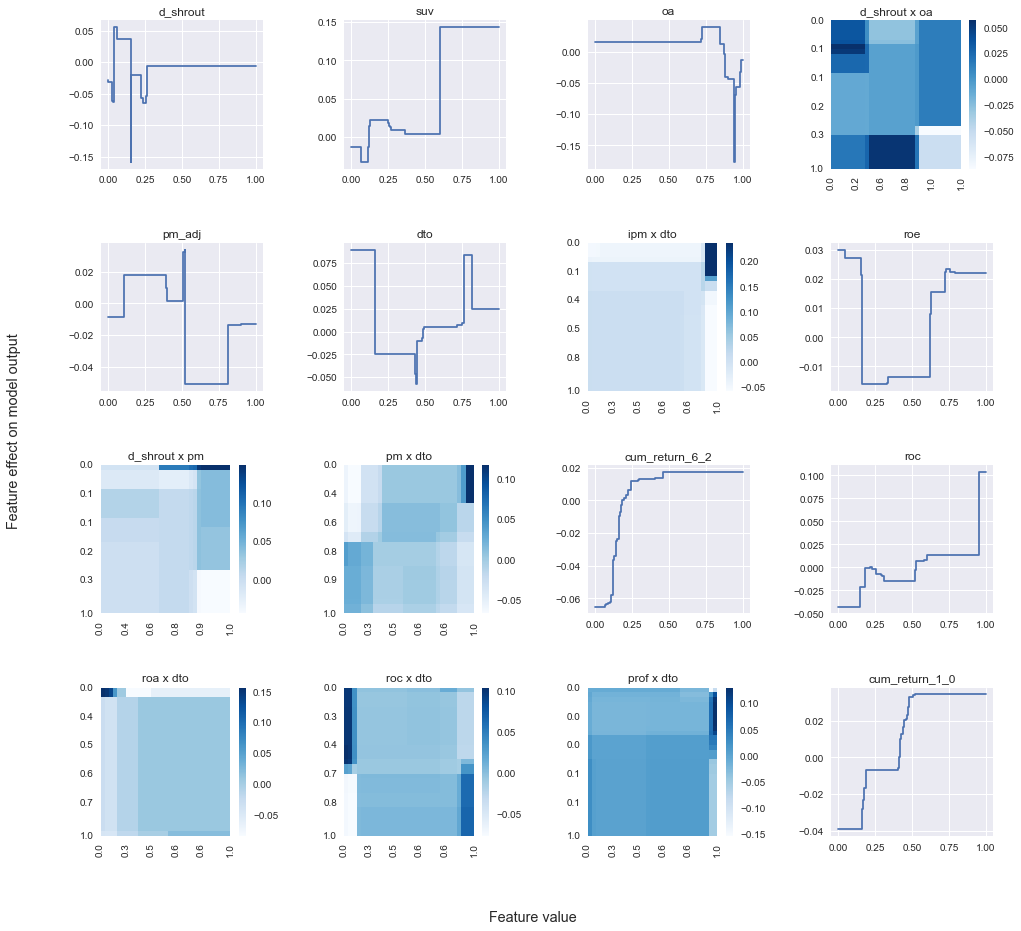

In [67]:
make_shape_function_grid(model_name='EBM', shape_data=shape_data_ebm, importance_sorted_idx=importance_sorted_idx_ebm_top_20, effect_names=effect_names, save=True, id='155')

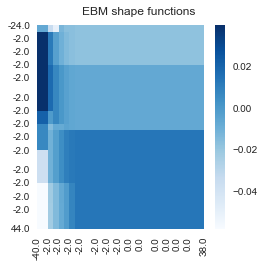

In [56]:
# plot interactions
selected_data = shape_data_ebm[65]
#interactions_shape_data_keys = shape_data_ebm[65].keys()

def plot_heatmap(interactions_shape_data):
    
    # extract and round x-, y-labels and variable contribution
    values_left = interactions_shape_data['left_names']
    values_left = [round(elem, 2) for elem in values_left] # round to 2 decimals
    values_right = interactions_shape_data['right_names']
    values_right = [round(elem, 2) for elem in values_right] # round
    value_contrib = interactions_shape_data['scores']

    # compute custom tick labels
    num_ticks = 15
    # the index of the position of yticks
    yticks = np.linspace(0, len(values_left) - 1, num_ticks, dtype=np.int32)
    xticks = np.linspace(0, len(values_right) - 1, num_ticks, dtype=np.int32)
    # the content of labels of these yticks
    try:
        yticklabels = [values_left[idx] for idx in yticks]
        xticklabels = [values_right[idx] for idx in xticks]
    except:
        pass

    # try plotting heatmap with an interaction
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15/4, 15/4))
    fig.suptitle("EBM shape functions", fontsize=12, y=0.95)

    sns.heatmap(value_contrib, cmap="Blues", ax=axs, yticklabels=yticklabels, xticklabels=xticklabels)
    axs.set_yticks(yticks, labels=yticklabels)
    axs.set_xticks(xticks, labels=xticklabels)

plot_heatmap(interactions_shape_data=selected_data)

### plot shapes gaminet

Preprocessing goal is to have 
- [x] feat importance df 
- [x] effect names
- shape data dict

like in EBM

In [43]:
# 1) feature importance df
def preprocess_gaminet_data(explain_data_gaminet):
    # extract feat importance from explain_data_gaminet
    feature_importance_gaminet = {'type': [], 'feature': [], 'importance score': []}
    for feature in explain_data_gaminet:
        feature_importance_gaminet['feature'].append(feature) # name
        feature_importance_gaminet['importance score'].append(explain_data_gaminet[feature]['importance']) # imp
        # type
        if 'vs.' in feature:
            feature_importance_gaminet['type'].append('interaction') # bivariate
        else:
            feature_importance_gaminet['type'].append('univariate')
    feature_importance_gaminet = pd.DataFrame(feature_importance_gaminet)

    # sort feat importance
    feature_importance_gaminet = feature_importance_gaminet.sort_values(by='importance score', ascending=False)
        
    # save feature indices by importance -> query shape data dict
    importance_sorted_idx_gaminet = feature_importance_gaminet.index
    #importance_sorted_idx_gaminet_top_20 = importance_sorted_idx_gaminet[:21]

    # 2) feature names of top 20 effects -> both main effects and interactions (effects)
    effect_names_gaminet = feature_importance_gaminet['feature'].values
    #effect_names_gaminet_top_20 = effect_names_gaminet[0:21]

    # 3) shape data gaminet: make it a list of dicts 
    shape_data_gaminet = []

    for feature in explain_data_gaminet:
        if 'vs.' not in feature:
            # main effects: one dict per effect containing (type), inputs, outputs
            single_effect_dict = {}
            single_effect_dict['type'] = 'univariate'
            single_effect_dict['names'] = explain_data_gaminet[feature]['inputs']
            single_effect_dict['scores'] = explain_data_gaminet[feature]['outputs']
            shape_data_gaminet.append(single_effect_dict)
        else:
            # pairwise effects: containing 'input1', 'input2', 'outputs', 'input1_ticks', 'input2_ticks', 'input1_labels', 'input2_labels'
            pairwise_effect_dict = {}
            pairwise_effect_dict['type'] = 'interaction' # bivariate
            pairwise_effect_dict['right_names'] = explain_data_gaminet[feature]['input1']
            pairwise_effect_dict['left_names'] = explain_data_gaminet[feature]['input2']
            pairwise_effect_dict['scores'] = explain_data_gaminet[feature]['outputs']
            # x and y ticks and labels
            pairwise_effect_dict['xticks'] = explain_data_gaminet[feature]['input1_ticks']
            pairwise_effect_dict['yticks'] = explain_data_gaminet[feature]['input2_ticks']
            pairwise_effect_dict['xticklabels'] = explain_data_gaminet[feature]['input1_labels']
            pairwise_effect_dict['yticklabels'] = explain_data_gaminet[feature]['input2_labels']
            shape_data_gaminet.append(pairwise_effect_dict)

    return feature_importance_gaminet, importance_sorted_idx_gaminet, effect_names_gaminet, shape_data_gaminet

In [44]:
feature_importance_gaminet, importance_sorted_idx_gaminet, effect_names_gaminet, shape_data_gaminet = preprocess_gaminet_data(explain_data_gaminet=explain_data_gaminet)

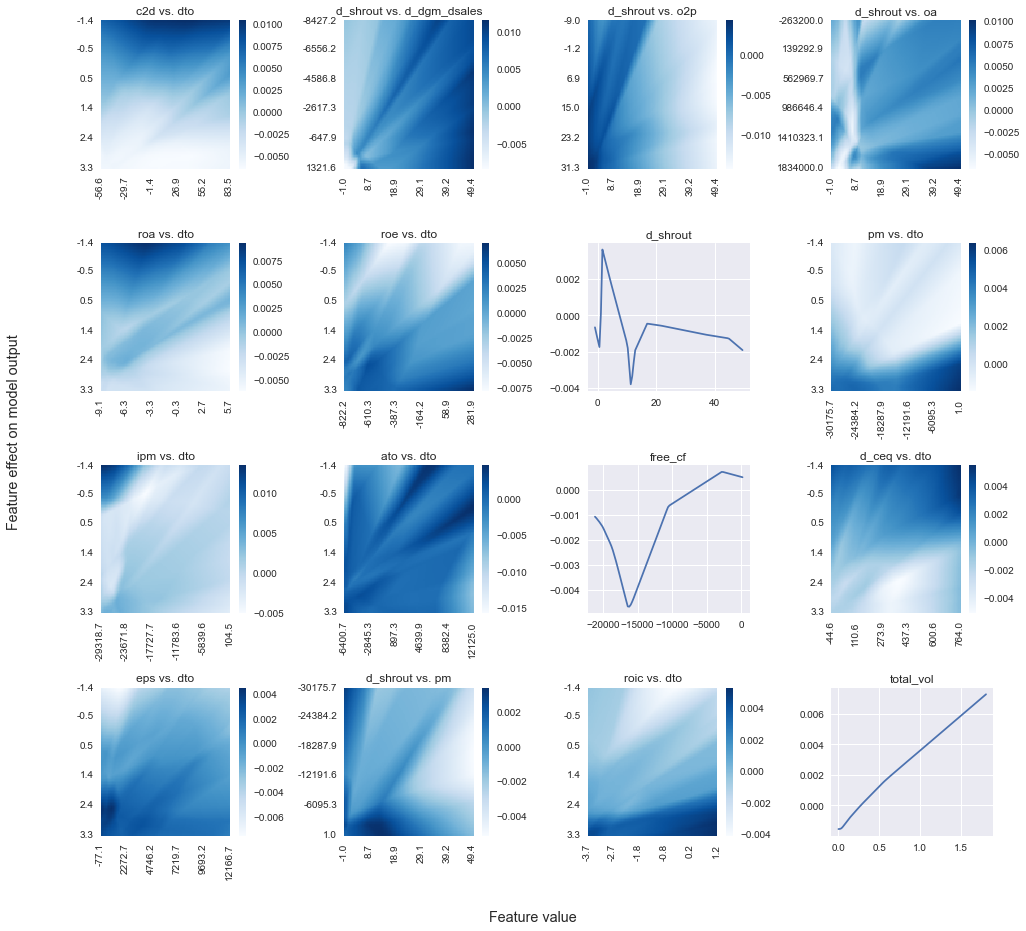

In [66]:
make_shape_function_grid(model_name='GAMI-Net', shape_data=shape_data_gaminet, \
    importance_sorted_idx=importance_sorted_idx_gaminet[:21], effect_names=effect_names_gaminet, save=True, id='151')

## Plot importances
- use gaminet util-function
- takes `data_dict` as input that needs feature names as keys and `importance` as values

In [71]:
def convert_importances_to_dict(feature_importance_df):
    """ 
    Transforms feature importance data frame into a dictionary 
    that can be used by gaminet function.
    """
    # store feature names and importances as keys/values
    importance_data_dict = {}
    keys = feature_importance_df.feature.to_list()
    values = feature_importance_df['importance score']

    # assign feat names as keys of a dict
    for i in keys:
        importance_data_dict[i] = {} 

    # assign importance as key value pair 
    for key, value in zip(importance_data_dict, values):
        importance_data_dict[key] = {'importance': value}
    return importance_data_dict

importance_data_ebm = convert_importances_to_dict(feature_importance_ebm)
importance_data_gaminet = convert_importances_to_dict(feature_importance_gaminet)

In [123]:
importance_data_gaminet

{'total_vol': {'importance': 0.48763526158934145},
 'idio_vol': {'importance': 0.2380023818566882},
 'beme': {'importance': 0.10038118949859326},
 'ol': {'importance': 0.04074992833519357},
 'beta': {'importance': 0.027644653626040804},
 'beme_adj': {'importance': 0.0224674246410039},
 'cum_return_12_7': {'importance': 0.018262930511822945},
 'ret_max': {'importance': 0.010483198061724373},
 'lturnover': {'importance': 0.00947356103711456},
 's2p': {'importance': 0.00822178052672014},
 'sat': {'importance': 0.005449786920164584},
 'c': {'importance': 0.004305029145014734},
 'cto': {'importance': 0.004038438444756524},
 'cum_return_36_13': {'importance': 0.0038846413752480096},
 'cum_return_12_2': {'importance': 0.003153103130808253},
 'a2me': {'importance': 0.0027295561495337796},
 'ret': {'importance': 0.0026505277031280442},
 'at_adj': {'importance': 0.002630131747689238},
 'spread_mean': {'importance': 0.0024428439984952107},
 'rel_to_high_price': {'importance': 0.001673306678022696

In [72]:
ebm_importance_dict_top_20 = dict(list(importance_data_ebm.items())[:21])
gaminet_importance_dict_top_20 = dict(list(importance_data_gaminet.items())[:21])

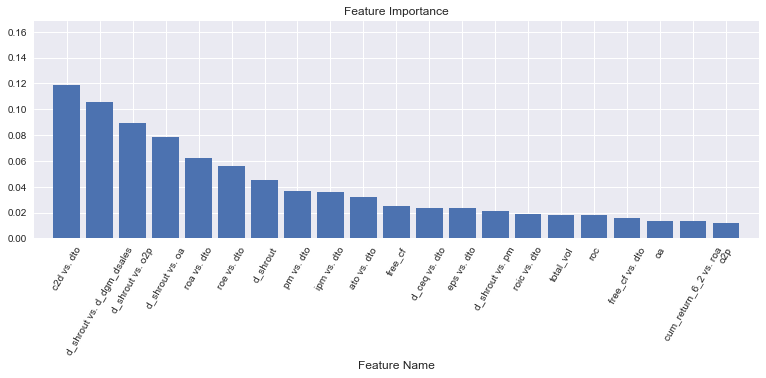

In [74]:
feature_importance_visualize(gaminet_importance_dict_top_20, folder=figure_dir, name="feature_importance_gaminet_151", save_png=True)

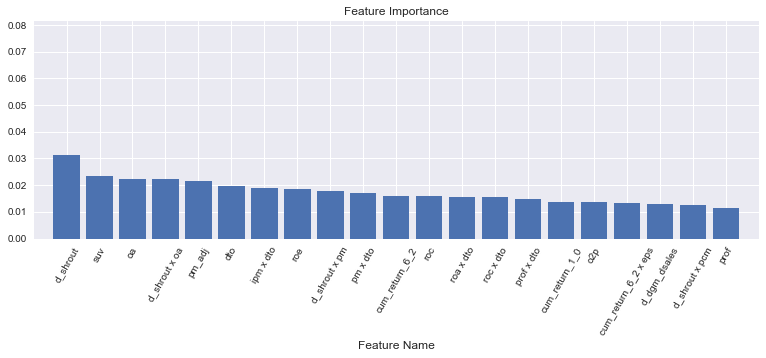

In [75]:
# plot top 20 shape functions ordered by importance
# TO-DO: plot ebm functions by importance (how?)
feature_importance_visualize(ebm_importance_dict_top_20, folder=figure_dir, name="feature_importance_ebm", save_png=True, save_eps=False)

In [78]:
print("ebm sum: ", fim_ebm.sum())
print("gami sum: ", fim_gami.sum())

ebm sum:  0.6809938720221466
gami sum:  1.0


In [83]:
### for scaling ebm importances to sum up to 1
from sklearn.utils.extmath import softmax

(84,)

In [81]:
fim_ebm.values.reshape(1,74).shape

(1, 74)

<AxesSubplot:>

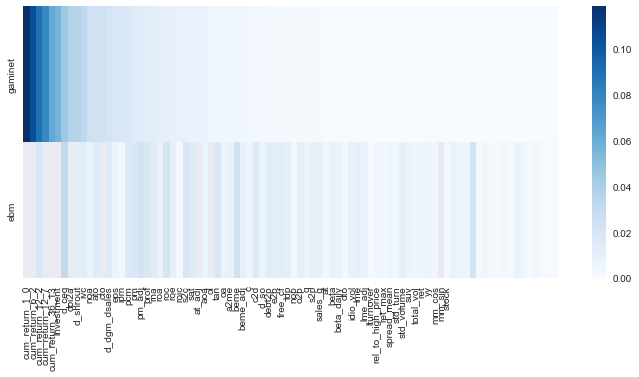

In [77]:
# draw heatmap to visualize feature importances
fim_gami = feature_importance_gaminet.iloc[:,2]
fim_ebm = feature_importance_ebm.iloc[:,2]
fim_gami = fim_gami.rename('gaminet')
fim_ebm = fim_ebm.rename('ebm')
importance_df = pd.DataFrame([fim_gami, fim_ebm])

#feature_names = 
plt.figure(figsize=(12,5))
sns.heatmap(importance_df, cmap='Blues', xticklabels=feature_names)

## Next steps:
- bring ebm importances to same scale as gaminet so that importances add up to 1.
- compare results with literature, i.e. freyberger
- write the paper!!!
- retrain ebm on normalized data (0;1) and compare results
- train gaminet from scratch on whole dataset for a few epochs and continue training on subsample for "fine tuning" 